In [10]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%matplotlib widget

In [12]:



from nfoursid.nfoursid import NFourSID
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from crnn.data_io import load_data
from crnn.utils import base as utils


dataset_dir = os.path.expanduser('~/coupled-msd/data/coupled-msd-routine/processed')
input_names = ['u_1']
output_names = ['y_1']


In [13]:
# load training data
train_inputs, train_outputs = load_data(
    input_names,
    output_names,
    "train",
    dataset_dir,
)
val_inputs, val_outputs = load_data(
    input_names,
    output_names,
    "validation",
    dataset_dir,
)
input_mean, input_std = utils.get_mean_std(train_inputs)
output_mean, output_std = utils.get_mean_std(train_outputs)
n_train_inputs = utils.normalize(train_inputs, input_mean, input_std)
n_train_outputs = utils.normalize(train_outputs, output_mean, output_std)

n_val_inputs = utils.normalize(val_inputs, input_mean, input_std)
n_val_outputs = utils.normalize(val_outputs, output_mean, output_std)

In [14]:


N = n_train_outputs[0].shape[0]
M = len(n_train_outputs)
nx = 8

subset_size_percent = 0.05
subset_size = int(subset_size_percent*M)
print(f'M:{M}, sub set size: {subset_size}')

idx = np.random.choice(range(M), subset_size)

num_rows = 10
num_cols = subset_size*N-2*num_rows +1

u = np.vstack(np.array(n_train_inputs)[idx])
y = np.vstack(np.array(n_train_outputs)[idx])


M:120, sub set size: 6


In [ ]:
# from https://github.com/AndyLamperski/pyN4SID did not work ver well
# from crnn.addon import ssid
# AID,BID,CID,DID,CovID,S = ssid.N4SID(u.T,y.T,num_rows,num_cols,nx)

In [16]:
io_data = pd.DataFrame(
    np.hstack([u, y]),
    columns=input_names + output_names
)

io_data.describe()


,u_1,y_1
count,45000.000000,45000.000000
mean,-0.026474,-0.021119
std,1.027132,1.021516
min,-1.740356,-2.792755
25%,-0.913420,-0.830430
50%,-0.007717,-0.041370
75%,0.872147,0.791088
max,1.718192,2.670098


In [17]:
n4sid = NFourSID(io_data, input_columns=input_names, output_columns=output_names,num_block_rows=10)
n4sid.subspace_identification()
ss, cov = n4sid.system_identification(rank=nx)

In [18]:
relative_matlab_data_folder = '../matlab/data'
mat_filename = 'n4sid_mat-coupled-msd-nx_8.mat'
from scipy.io import loadmat

mat_data = loadmat(f'{relative_matlab_data_folder}/{mat_filename}')


In [19]:

dt = 0.2
M_val = len(n_val_inputs)
N_val, nd = n_val_inputs[0].shape
_, ne = n_val_outputs[0].shape

mat vs true: Accumulated absolute error 1416.86, mean absolute error 0.19 mean squared error 0.05.
py-NFourSID vs true: Accumulated absolute error 1438.25, mean absolute error 0.19 mean squared error 0.05.
mat vs py-NFourSID: Accumulated absolute error 907.99, mean absolute error 0.12 mean squared error 0.02.


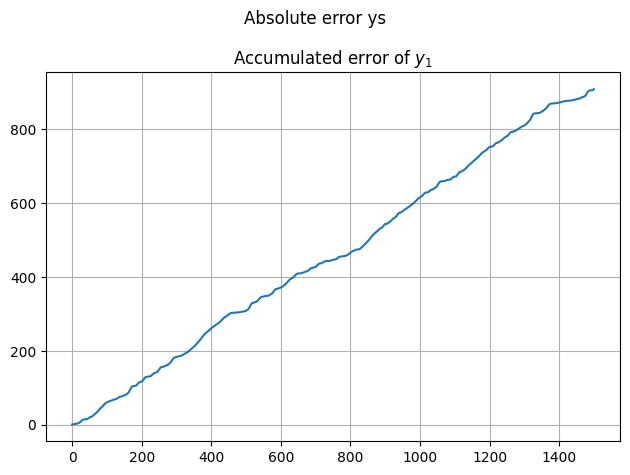

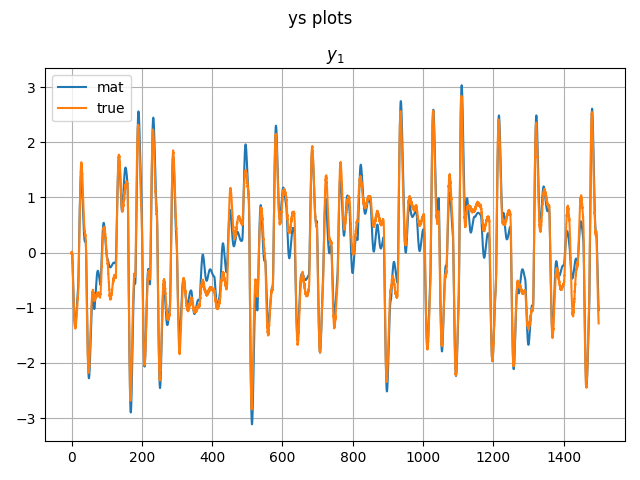

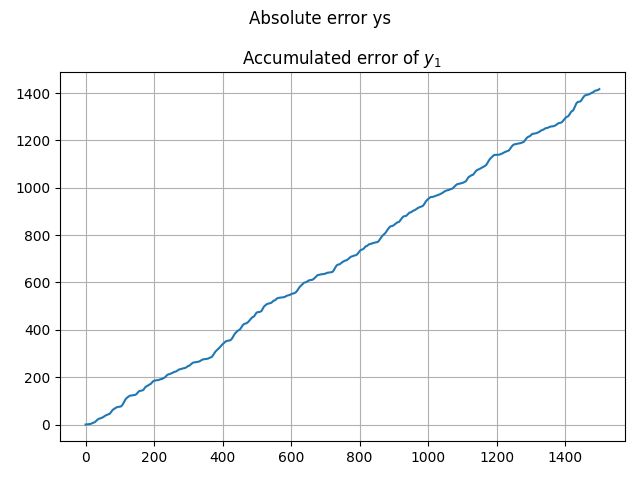

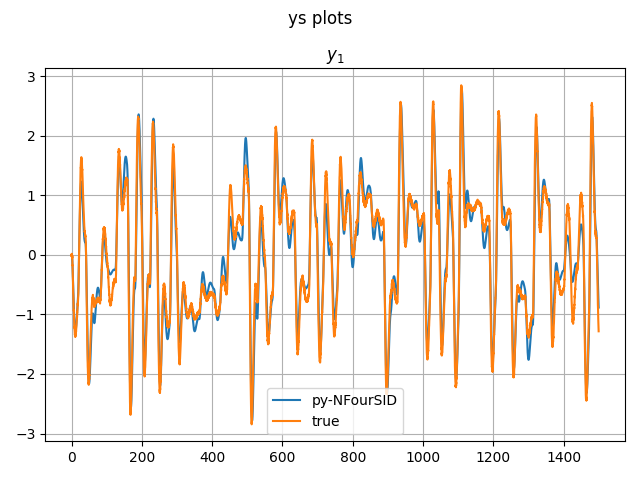

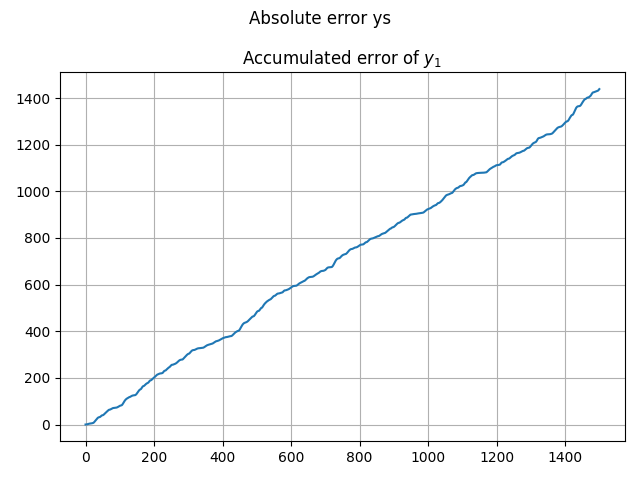

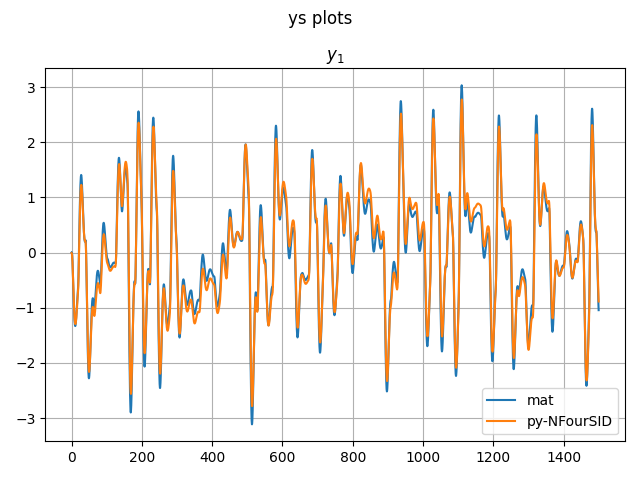

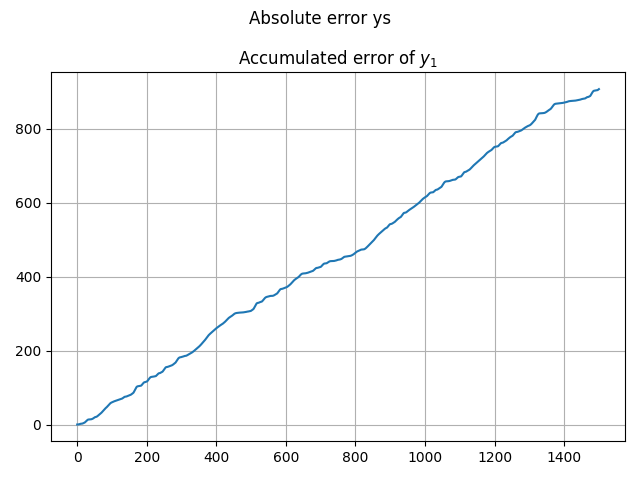

In [21]:
from statesim.model.statespace import Linear
from statesim.simulator import DiscreteSimulator, SimulationData
from statesim.analysis import plot_simulation_results as plt_ss

mat_sys = Linear(mat_data['A'], mat_data['B'], mat_data['C'], mat_data['D'])
py_b_sys = Linear(ss.a,ss.b,ss.c,ss.d)

sim = DiscreteSimulator(N_val*dt, dt)

x0 = np.zeros((nx,1))
ds = [d_i.reshape(nd,1) for d_i in n_val_inputs[0]]

true = SimulationData(
    [np.zeros((nx,1)) for _ in range(N_val)],
    ds,
    [e_i.reshape(ne,1) for e_i in n_val_outputs[0]],
    np.linspace(0,(N_val-1)*dt,N_val),
    'true'
)

res_list = []
for sys, name in zip([mat_sys,py_b_sys], ['mat','py-NFourSID']):
    res = sim.simulate(sys, x0,ds,name)
    plt_ss.plot_comparison([res, true], type='ys')
    res_list.append(res)

plt_ss.plot_comparison(res_list, type='ys')

    




In [ ]:
from scipy.io import loadmat
mat_file = './data/test.mat'
report = loadmat(mat_file)


KeyError: 'Fit'

In [6]:
report['re']['Fit']

array([[array([[(array([[85.04205748],
                       [89.51478888],
                       [73.67280017]]), array([[1.32000099e-05]]), array([[0.10267997]]), array([[1.32023284e-05]]), array([[-3441113.53516323]]), array([[-3441113.52374649]]), array([[-11.23511735]]), array([[-3440377.58751094]]))]],
              dtype=[('FitPercent', 'O'), ('LossFcn', 'O'), ('MSE', 'O'), ('FPE', 'O'), ('AIC', 'O'), ('AICc', 'O'), ('nAIC', 'O'), ('BIC', 'O')])                                                                                        ]],
      dtype=object)